In [465]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import optim
from sklearn.utils import shuffle

# Read data
Load data into dataframes

In [466]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [467]:
df_train.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

# Compute LogSalePrice
You can optionally try to predict this if you want. This implementation predicts actual SalePrice

In [468]:
df_train['LogSalePrice'] = np.log(df_train['SalePrice'])

In [469]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216


# Preprocessing
For all numeric columns , we are replacing unknown with median

In [470]:
cols = df_train.columns
numeric_cols = set(df_train._get_numeric_data().columns)

In [471]:
categoric_cols = list(set(cols) - set(numeric_cols))

In [472]:
numeric_cols.remove('Id')
numeric_cols.remove('SalePrice')
numeric_cols.remove('LogSalePrice')
print (" Numeric columns are {} ".format(numeric_cols))

 Numeric columns are set(['3SsnPorch', 'BsmtFullBath', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'OverallCond', 'LotArea', 'GrLivArea', 'YearRemodAdd', 'MasVnrArea', '1stFlrSF', 'Fireplaces', 'EnclosedPorch', 'LotFrontage', 'MiscVal', 'OverallQual', 'KitchenAbvGr', 'WoodDeckSF', 'MoSold', 'BsmtHalfBath', 'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtUnfSF', 'GarageYrBlt', 'FullBath', 'YrSold', 'MSSubClass', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'PoolArea', 'ScreenPorch', 'BedroomAbvGr', 'LowQualFinSF', 'GarageArea', 'GarageCars']) 


# Log1p normalization
You can uncomment the code below if you want log1p normalizaition.
In my experience 0-1 normalization turned out to be better

In [475]:
'''
for col in numeric_cols:
    df_test[col] = np.log1p(df_test[col])
    
for col in numeric_cols:
    df_train[col] = np.log1p(df_train[col])
'''

'\nfor col in numeric_cols:\n    df_test[col] = np.log1p(df_test[col])\n    \nfor col in numeric_cols:\n    df_train[col] = np.log1p(df_train[col])\n'

# Centering the features
We are scaling down features to 0 mean and unit variance.
This helps quite a bit in making the predictions

In [476]:
for col in numeric_cols:
    col_median = df_train[col].median()
    df_train[col].fillna(col_median, inplace=True)
    df_test[col].fillna(col_median, inplace=True)

col_mean = {}
col_std = {}
for col in numeric_cols:
    col_mean[col] = df_train[col].mean()
    col_std[col] = df_train[col].std()

for col in numeric_cols:
    df_test[col] = (df_test[col] - col_mean[col]) / col_std[col]

for col in numeric_cols:
    df_train[col] = (df_train[col] - col_mean[col]) / col_std[col]

In [477]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,0.424317,RL,-0.078869,-0.133225,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,-0.190416,-1.908671,0.139058,WD,Normal,208500,12.247694
1,2,-1.124816,RL,0.572523,0.113374,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,-0.190416,-0.279805,-0.614042,WD,Normal,181500,12.109011
2,3,0.424317,RL,0.062519,0.419905,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,-0.190416,0.920613,0.139058,WD,Normal,223500,12.317167
3,4,0.644852,RL,-0.329448,0.103282,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,-0.190416,-1.908671,-1.367517,WD,Abnorml,140000,11.849398
4,5,0.424317,RL,0.725840,0.878130,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,-0.190416,1.537157,0.139058,WD,Normal,250000,12.429216


In [478]:
print ("There are {} numeric columns and {} categoric columns".format(len(numeric_cols), len(categoric_cols)))

There are 36 numeric columns and 43 categoric columns


For all categoric columns, we are computing vocab with min count

# Vocab for categorical features
Identify the vocab for categorical features. Omit categorical
features with low coverage

In [482]:
MIN_FRQ_FOR_VOCAB = 5
MIN_COVERAGE_FOR_FEATURE = 200
cat_col_vocab = {}
feat_count = 0
for col in categoric_cols:
    col_summary = df_train[col].value_counts()
    col_vocab = [k for (k,v) in col_summary.items() if v >= MIN_FRQ_FOR_VOCAB]
    col_coverage = sum(col_summary.values)
    if col_coverage >= MIN_COVERAGE_FOR_FEATURE:
        cat_col_vocab[col] = col_vocab
        feat_count += len(col_vocab)
        print ("Summary for column={}, coverage = {}, vocab = {}".format(col, col_coverage, cat_col_vocab[col]))
    else:
        print ("Ignored column={} due to low coverage({})".format(col, col_coverage))
print ("Feature count = {}".format(feat_count))

Summary for column=MasVnrType, coverage = 1452, vocab = ['None', 'BrkFace', 'Stone', 'BrkCmn']
Summary for column=LotConfig, coverage = 1460, vocab = ['Inside', 'Corner', 'CulDSac', 'FR2']
Summary for column=GarageQual, coverage = 1379, vocab = ['TA', 'Fa', 'Gd']
Summary for column=Exterior1st, coverage = 1460, vocab = ['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', 'Plywood', 'CemntBd', 'BrkFace', 'WdShing', 'Stucco', 'AsbShng']
Summary for column=GarageFinish, coverage = 1379, vocab = ['Unf', 'RFn', 'Fin']
Summary for column=Electrical, coverage = 1459, vocab = ['SBrkr', 'FuseA', 'FuseF']
Summary for column=BsmtQual, coverage = 1423, vocab = ['TA', 'Gd', 'Ex', 'Fa']
Summary for column=BsmtExposure, coverage = 1422, vocab = ['No', 'Av', 'Gd', 'Mn']
Summary for column=Foundation, coverage = 1460, vocab = ['PConc', 'CBlock', 'BrkTil', 'Slab', 'Stone']
Summary for column=GarageType, coverage = 1379, vocab = ['Attchd', 'Detchd', 'BuiltIn', 'Basment', 'CarPort', '2Types']
Summary for column=B

# Utils and Featurizer
Now we define util functions to extract features and convert to onehot if needed

In [483]:
def one_hot_from_numeric(feature, max_dim, unknown_value_dim=0):
    feature_vec = torch.zeros(max_dim + 2)
    if feature is not None and not np.isnan(feature):
        feature_vec[int(feature)+1] = 1
    else:
        feature_vec[unknown_value_dim] = 1
    return feature_vec

def one_hot_from_cat(feature, val_list= ['S', 'C', 'Q']):
    max_dim = len(val_list)
    feature_vec = torch.zeros(max_dim + 1)
    if feature is None:
        feature_vec[0] = 1
    else:
        for i in range(len(val_list)):
            if feature == val_list[i]:
                feature_vec[i+1] = 1
    return feature_vec

def real_feature(val, default_val=None):
    feature_vec = torch.zeros(1)
    if val is not None and not np.isnan(val):
        feature_vec[0] = val
    elif default_val is not None:
        feature_vec[0] = default_val
    return feature_vec

In [484]:
def get_featurized_data(row, extractLabel=True,
                        numeric_feature_set = {'1stFlrSF'},
                        cat_col_vocab = {}):
    features = []
    for numeric_col in numeric_feature_set:
        features.append(real_feature(row[numeric_col]))
    for cat_col, vocab in cat_col_vocab.iteritems():
        features.append(one_hot_from_cat(row[cat_col], vocab))
    Y = None
    if extractLabel:
        Y = real_feature(int(row['SalePrice']))
#       Y = real_feature(int(row['LogSalePrice']))
    X = torch.cat(features)
    return row['Id'], X, Y

In [485]:
get_featurized_data(df_train.iloc[1], True, {'1stFlrSF'})

(2, tensor([0.4183]), tensor([181500.]))

In [486]:
def get_train_and_validation_set(df_train,
                                 bs=128,
                                 train_frac=0.9, 
                                 numeric_feature_set = {'1stFlrSF'},
                                 cat_col_vocab = {}):
    df_train = shuffle(df_train)
    ids = []
    X_train = []
    Y_train = []
    for idx, row in df_train.iterrows():
        record_id, X_row, Y_row = get_featurized_data(row, True, numeric_feature_set, cat_col_vocab)
        X_train.append(X_row)
        Y_train.append(Y_row)
        ids.append(record_id)
        
    num_samples = len(X_train)
    num_features = X_train[0].shape[0]
    print ("Num_samples = {}, Num_features = {} from training data file".format(num_samples, num_features))

    split_point = int(train_frac*num_samples)
    tensor_x_train = torch.stack(X_train[:split_point]) # transform to torch tensors
    tensor_y_train = torch.stack(Y_train[:split_point])

    train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
    train_dataloader = DataLoader(train_dataset, batch_size=bs)
    #len(train_dataset)) # create your dataloader

    print ("split point is : {}".format(split_point))

    tensor_x_valid = torch.stack(X_train[split_point:]) # transform to torch tensors
    tensor_y_valid = torch.stack(Y_train[split_point:])

    validation_dataset = TensorDataset(tensor_x_valid,tensor_y_valid) # create your datset
    validation_dataloader = DataLoader(validation_dataset)
    return train_dataloader, validation_dataloader, num_features, numeric_feature_set

In [487]:
numeric_feature_set = {'3SsnPorch', 'BsmtFullBath', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 
                       'OverallCond', 'LotArea', 'GrLivArea', 'YearRemodAdd', 'MasVnrArea', 
                       '1stFlrSF', 'Fireplaces', 'EnclosedPorch', 'LotFrontage', 'MiscVal', 
                       'OverallQual', 'KitchenAbvGr', 'WoodDeckSF', 'MoSold', 'BsmtHalfBath', 
                       'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtUnfSF', 'GarageYrBlt', 'FullBath',
                       'YrSold', 'MSSubClass', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'PoolArea', 
                       'ScreenPorch', 'BedroomAbvGr', 'LowQualFinSF', 'GarageArea', 'GarageCars'}
train_dataloader, validation_dataloader, num_features, featureList = get_train_and_validation_set(
    df_train, 128, 0.9, numeric_feature_set)

Num_samples = 1460, Num_features = 36 from training data file
split point is : 1314


In [488]:
one_hot_from_cat(df_train.iloc[5]['SaleCondition'], cat_col_vocab['SaleCondition'])

tensor([0., 1., 0., 0., 0., 0.])

# Define DNNRegressor
We are defining last layer as RELU to avoid nan in eval computation(log(x<0) is undefined

In [489]:
class SimpleNN(nn.Module):
    def __init__(self, X_in=91):
        super(SimpleNN, self).__init__()
        self.lin1 = nn.Linear(X_in, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 32)
        self.lin4 = nn.Linear(32, 8)
        self.final_layer = nn.Linear(8, 1)
        
    def forward(self, X):
        X = self.lin1(X)
        X = F.relu(X)
        X = self.lin2(X)
        X = F.relu(X)
        X = self.lin3(X)
        X = F.relu(X)
        X = self.lin4(X)
        X = F.relu(X)
        X = self.final_layer(X)
        # Eval function is taking log(Pred) and hence RELU on prediction is important to avoid nan
        return F.relu(X)

In [490]:
class RMSELossOnLogPred(nn.Module):
    def __init__(self, eps=1e-6):
        super(RMSELossOnLogPred, self).__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(torch.log(yhat.clamp_min(self.eps)) ,torch.log(y)) + self.eps)
        return loss

In [491]:
def get_eval_metric(model, dataset):
    y_validation = []
    y_hat = []
    for i in range(len(dataset)):
        x_i = dataset[i][0]
        y_i = dataset[i][1]
        y_hat_i = model(x_i)
        y_validation.append(y_i.item())
        y_hat.append(y_hat_i.item())
    eval_result = np.sqrt(F.mse_loss(torch.log(torch.tensor(y_validation)), torch.log(torch.tensor(y_hat))).item())
    return y_validation, y_hat, eval_result

In [492]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.sum(), len(xb)

In [493]:
def fitModel(model, criterion, optimizer, train_dl, valid_dl, epochs):
    train_loss = []
    train_eval = []
    valid_loss = []
    valid_eval = []
    for epoch in range(epochs):
        model.train()
        losses, nums = zip(*[loss_batch(model, criterion, xb, yb, optimizer) for xb, yb in train_dl])
        cur_train_loss = np.sqrt(np.sum(np.multiply(losses, nums) / np.sum(nums)).item())

        model.eval()
        train_loss.append(np.sqrt(cur_train_loss))
        _, _, train_eval_result = get_eval_metric(model, train_dl.dataset)
        train_eval.append(train_eval_result)

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)        
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, criterion, xb, yb) for xb, yb in valid_dl])
            cur_val_loss = np.sqrt(np.sum(np.multiply(losses, nums) / np.sum(nums)).item())
            valid_loss.append(np.sqrt(cur_val_loss))
            _, _, validation_eval_result = get_eval_metric(model, valid_dl.dataset)
            valid_eval.append(validation_eval_result)
            print(epoch, np.sqrt(cur_train_loss), np.sqrt(cur_val_loss), train_eval_result, validation_eval_result)
            if validation_eval_result > train_eval_result + 0.02 and validation_eval_result <=0.13:
                print ("Early stopping due to divergence on validation set")
                break
    return train_loss, valid_loss, train_eval, valid_eval

In [494]:
def gen_dataset_and_train_model(df_train,
                                batch_size=128,
                                train_frac=0.9, 
                                num_epochs = 100,
                                learning_rate = 0.001,
                                numeric_feature_set = {'1stFlrSF'},
                                cat_col_vocab = {}):
    train_dataloader, validation_dataloader, num_features, _ = get_train_and_validation_set(
        df_train, batch_size, train_frac, numeric_feature_set, cat_col_vocab)
    model = SimpleNN(num_features)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    train_loss, valid_loss, train_eval, valid_eval = fitModel(
        model, RMSELossOnLogPred(),optimizer, train_dataloader, validation_dataloader, num_epochs)
    return model, train_loss, valid_loss,  train_eval, valid_eval, train_dataloader, validation_dataloader

# Train model
Now we train a model with early stopping

In [495]:
num_epochs = 300
batch_size=16
train_frac=0.8
learning_rate = 0.001
numeric_feature_set = {'3SsnPorch', 'BsmtFullBath', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 
                       'OverallCond', 'LotArea', 'GrLivArea', 'YearRemodAdd', 'MasVnrArea', 
                       '1stFlrSF', 'Fireplaces', 'EnclosedPorch', 'LotFrontage', 'MiscVal', 
                       'OverallQual', 'KitchenAbvGr', 'WoodDeckSF', 'MoSold', 'BsmtHalfBath', 
                       'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtUnfSF', 'GarageYrBlt', 'FullBath',
                       'YrSold', 'MSSubClass', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'PoolArea', 
                       'ScreenPorch', 'BedroomAbvGr', 'LowQualFinSF', 'GarageArea', 'GarageCars'}
model, train_loss, valid_loss, train_eval, valid_eval, train_dl, validation_dl = gen_dataset_and_train_model(
    df_train, batch_size, train_frac, num_epochs, learning_rate, numeric_feature_set, cat_col_vocab)
    

Num_samples = 1460, Num_features = 278 from training data file
split point is : 1168
(0, 1.844971600884042, 1.7443647553078536, 9.266391149948703, 9.267736390574333)
(1, 1.6853290989385856, 1.6279780991912425, 7.034029669739486, 7.036307588586586)
(2, 1.5826820374837929, 1.5352767380250245, 5.568028649256434, 5.571143132537761)
(3, 1.4914618207614347, 1.444965897968586, 4.374730129092831, 4.378904289905337)
(4, 1.4069814036387212, 1.3652018922710643, 3.492495802683619, 3.497845531571103)
(5, 1.3304934976941871, 1.288501819222132, 2.7795768591404593, 2.786334501468021)
(6, 1.2493309755303057, 1.1995506338621955, 2.1004740225446175, 2.1093685573903347)
(7, 1.1601005536402793, 1.1063056914325085, 1.5378065067353541, 1.5497679967449132)
(8, 1.0683130846391844, 1.0077527843791099, 1.0814971156335356, 1.0980347221839213)
(9, 0.9712238728859465, 0.8968696994649513, 0.7145289160321003, 0.7383556429403676)
(10, 0.8681800079938871, 0.7808142502913683, 0.44758384744878255, 0.4822861484379427)
(11

Text(0.5,1,'Training and validation loss for model from i = 1')

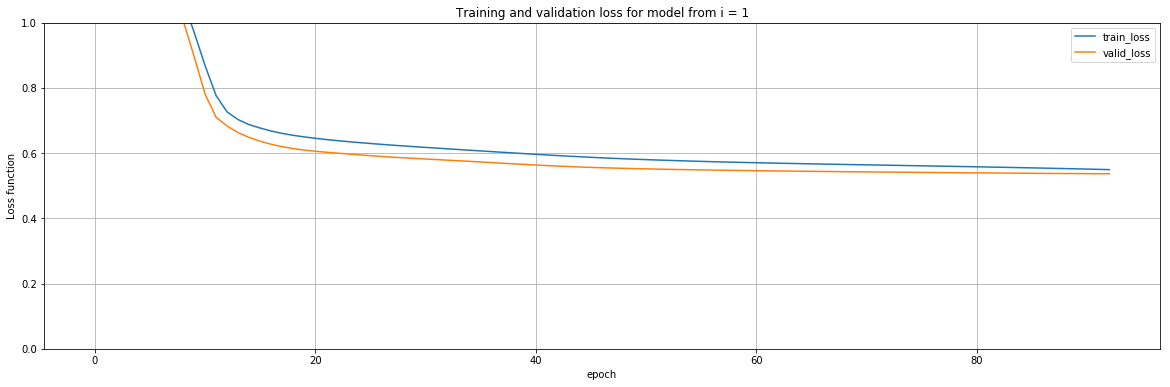

In [496]:
plt.figure(figsize=(20,6))
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, valid_loss)
plt.ylim([0, 1])
plt.grid(True)
plt.legend(['train_loss', 'valid_loss'])
plt.xlabel("epoch")
plt.ylabel("Loss function")
plt.title("Training and validation loss for model from i = {}".format(1))

Text(0.5,1,'Training and validation evaluation(MSE on log(pred)) for model from i = 1')

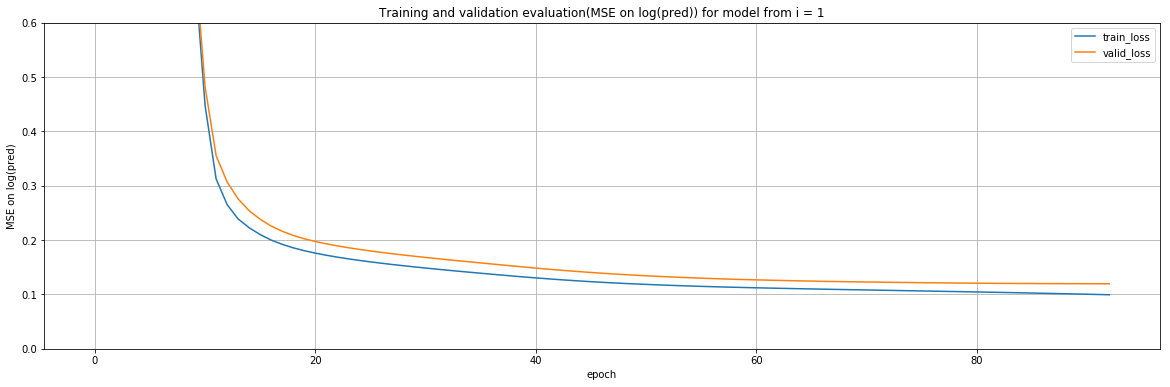

In [497]:
plt.figure(figsize=(20,6))
epochs = range(len(train_eval))
plt.plot(epochs, train_eval, valid_eval)
plt.ylim([0, 0.6])
plt.grid(True)
plt.legend(['train_loss', 'valid_loss'])
plt.xlabel("epoch")
plt.ylabel("MSE on log(pred)")
plt.title("Training and validation evaluation(MSE on log(pred)) for model from i = {}".format(1))

Text(0.5,1,'Eval result = 0.119628590953')

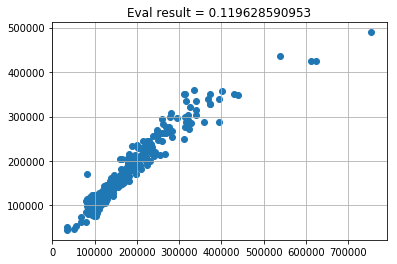

In [498]:
y_validation, y_hat, eval_result = get_eval_metric(model, validation_dl.dataset)
plt.scatter(y_validation, y_hat)
plt.grid(True)
plt.title("Eval result = {}".format(eval_result))

In [499]:
#eval_result = np.sqrt(F.mse_loss(torch.log(torch.tensor(y_validation)), torch.log(torch.tensor(y_hat))).item())


Text(0.5,1,'Eval result = 0.0994599568042')

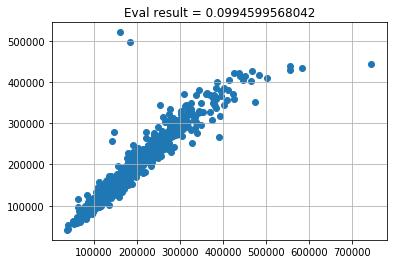

In [500]:
y_validation, y_hat, eval_result = get_eval_metric(model, train_dl.dataset)
plt.scatter(y_validation, y_hat)
plt.grid(True)
plt.title("Eval result = {}".format(eval_result))

In [501]:
ids = []
X_pred = []
Y_pred = []
for idx, row in df_test.iterrows():
    record_id, X_row, _ = get_featurized_data(row, False, numeric_feature_set, cat_col_vocab)
    X_pred.append(X_row)
    ids.append(record_id)

In [502]:
f = open('preds.txt', 'w')
f.write("Id,SalePrice\n")
for i in range(len(X_pred)):
    y_pred = model(X_pred[i]).item()
    Y_pred.append(y_pred)
    f.write("{},{}\n".format(ids[i], y_pred))
f.close()